In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

In [4]:
!pip install qiskit

     |████████████████████████████████| 6.1 MB 7.7 MB/s 
     |████████████████████████████████| 18.0 MB 126 kB/s 
     |████████████████████████████████| 234 kB 61.3 MB/s 
     |████████████████████████████████| 207 kB 48.5 MB/s 
     |████████████████████████████████| 2.1 MB 28.9 MB/s 
     |████████████████████████████████| 199 kB 58.5 MB/s 
     |████████████████████████████████| 1.4 MB 33.7 MB/s 
     |████████████████████████████████| 635 kB 40.9 MB/s 
     |████████████████████████████████| 68 kB 7.4 MB/s 
     |████████████████████████████████| 33.9 MB 19 kB/s 
     |████████████████████████████████| 943 kB 36.6 MB/s 
     |████████████████████████████████| 49 kB 6.8 MB/s 
     |████████████████████████████████| 3.2 MB 46.9 MB/s 
     |████████████████████████████████| 6.3 MB 45.8 MB/s 
  Created wheel for qiskit: filename=qiskit-0.28.0-py3-none-any.whl size=11090 sha256=667e9d92ef16c6e91675c9056666d2377071367be059fff21714042ae7d8a619
  Stored in directory: /root/.cache/pip/whe

In [14]:
import qiskit
from qiskit import IBMQ, transpile, assemble
from qiskit.visualization import *

In [15]:
provider = IBMQ.load_account()

configrc.store_credentials:WARNING:2021-08-01 09:26:15,735: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2021-08-01 09:26:16,005: Credentials are already in use. The existing account in the session will be replaced.


In [18]:
class QuantumCircuit:
    def __init__(self, n_qubits, backend, shots):
        self._circuit = qiskit.QuantumCircuit(n_qubits)

        all_qubits = [i for i in range(n_qubits)]
        self.theta = qiskit.circuit.Parameter('theta')

        self._circuit.h(all_qubits)
        self._circuit.barrier()
        self._circuit.ry(self.theta, all_qubits)
        
        self._circuit.measure_all()

        self.backend = backend
        self.shots = shots

    def run(self, thetas):
        t_qc = transpile(self._circuit, self.backend)
        qobj = assemble(t_qc, shots=self.shots, parameter_binds=[{self.theta: theta} for theta in thetas])

        job = self.backend.run(qobj)
        result = job.result().get_counts()

        counts = np.array(list(result.values()))
        states = np.array(list(result.keys())).astype(float)

        probabilities = counts / self.shots
        expectation = np.sum(states * probabilities)

        return np.array([expectation])

In [23]:
simulator = qiskit.Aer.get_backend('aer_simulator')

circuit = QuantumCircuit(1, simulator, 100)
x = circuit.run([np.pi])[0]
print('Expected value for rotation pi', x)
circuit._circuit.draw()

Expected value for rotation pi 0.47


┌───┐ ░ ┌───────────┐ ░ ┌─┐
   q_0: ┤ H ├─░─┤ Ry(theta) ├─░─┤M├
        └───┘ ░ └───────────┘ ░ └╥┘
meas: 1/═════════════════════════╩═
                                 0

In [25]:
class HybridFunction(Function):

    @staticmethod
    def forward(ctx, input, quantum_circuit, shift):
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit

        expectation_z = ctx.quantum_circuit.run(input[0].tolist())
        result = torch.tensor([expectation_z])
        ctx.save_for_backward(input, result)

        return result
    
    @staticmethod
    def backward(ctx, grad_output):
        input, expectation_z = ctx.saved_tensors
        input_list = np.array(input.tolist())

        shift_right = input_list + np.ones(input_list.shape) * ctx.shift
        shift_left = input_list - np.ones(input_list.shape) * ctx.shift

        gradients = []
        for i in range(len(input_list)):
            expectation_right = ctx.quantum_circuit.run(shift_right[i])
            expectation_left = ctx.quantum_circuit.run(shift_left[i])

            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradients.append(gradient)
        gradients = np.array([gradients]).T

        return torch.tensor([gradients]).float() * grad_output.float(), None, None


In [26]:
class Hybrid(nn.Module):
    
    def __init__(self, backend, shots, shift):
        super(Hybrid, self).__init__()
        self.quantum_circuit = QuantumCircuit(1, backend, shots)
        self.shift = shift
    
    def forward(self, input):
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)

In [27]:
n_samples = 100

X_train = datasets.MNIST(root='./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

mask = np.append(np.where(X_train.targets == 0)[0][:n_samples], 
                np.where(X_train.targets == 1)[0][:n_samples])

X_train.data = X_train.data[mask]
X_train.targets = X_train.targets[mask]

train_loader = torch.utils.data.DataLoader(X_train, batch_size=1, shuffle=True)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


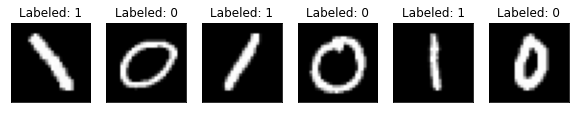

In [32]:
n_samples_show = 6

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

while n_samples_show > 0:
    images, targets = data_iter.__next__()

    axes[n_samples_show - 1].imshow(images[0].numpy().squeeze(), cmap='gray')
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets.item()))
    
    n_samples_show -= 1

In [29]:
n_samples = 50

X_test = datasets.MNIST(root='./data', train=False, download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))

mask = np.append(np.where(X_test.targets == 0)[0][:n_samples], 
                np.where(X_test.targets == 1)[0][:n_samples])

X_test.data = X_test.data[mask]
X_test.targets = X_test.targets[mask]

test_loader = torch.utils.data.DataLoader(X_test, batch_size=1, shuffle=True)

In [33]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 1)
        self.hybrid = Hybrid(qiskit.Aer.get_backend('aer_simulator'), 100, np.pi / 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(1, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.hybrid(x)
        return torch.cat((x, 1 - x), -1)

In [34]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 20
loss_list = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Training [5%]	Loss: -0.8019
Training [10%]	Loss: -0.9311
Training [15%]	Loss: -0.9388
Training [20%]	Loss: -0.9461
Training [25%]	Loss: -0.9505
Training [30%]	Loss: -0.9575
Training [35%]	Loss: -0.9622
Training [40%]	Loss: -0.9603
Training [45%]	Loss: -0.9724
Training [50%]	Loss: -0.9778
Training [55%]	Loss: -0.9800
Training [60%]	Loss: -0.9775
Training [65%]	Loss: -0.9864
Training [70%]	Loss: -0.9883
Training [75%]	Loss: -0.9839
Training [80%]	Loss: -0.9847
Training [85%]	Loss: -0.9856
Training [90%]	Loss: -0.9907
Training [95%]	Loss: -0.9917
Training [100%]	Loss: -0.9867


Text(0, 0.5, 'Neg Log Likelihood Loss')

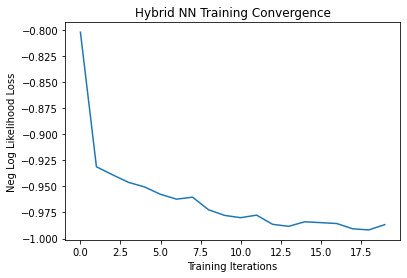

In [35]:
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

In [36]:
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100))

Performance on test data:
	Loss: -0.9788
	Accuracy: 100.0%


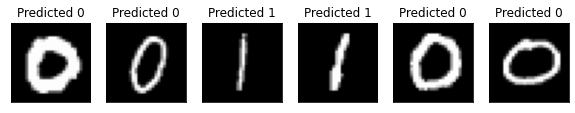

In [37]:
n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 

        axes[count].imshow(data[0].numpy().squeeze(), cmap='gray')

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title('Predicted {}'.format(pred.item()))
        
        count += 1